# MostlyAI SDK Tutorial — Hands-On

This notebook drives the first hands-on block of the workshop. The introductory talk covered theory and context; here we dive straight into the practical workflow you will replicate with the MostlyAI SDK.

## Session Flow

- Environment setup,

- The basics:
  - Load and inspect the Titanic dataset,
  - Configure and train a MostlyAI generator in local mode,
  - Generate synthetic samples and probe the generator,
  - Produce a Quality Assurance (QA) report,
  - Run a Train-on-Synthetic / Test-on-Real (TSTR) smoke test
  - Any questions before the coffee break?

- Uses of SD:
  - Imputation,
  - Rebalancing

- Privacy-preserving SD
- Fair SD

## 0. Environment Setup

### Locally:

Optional if you run this Notebook locally: set up a fresh Python environment with **uv** (fast & simple)

**uv** is a drop-in replacement for `pip` + `venv` that's much faster.  
Copy this whole cell into your notebook as a single Markdown cell.

#### 1) Install `uv`

**macOS / Linux**
```bash
curl -LsSf https://astral.sh/uv/install.sh | sh
# then reload your shell OR:
export PATH="$HOME/.local/bin:$PATH"
```

**Windows (PowerShell)**
```powershell
iwr https://astral.sh/uv/install.ps1 -UseBasicParsing | iex
```

**Check it works**
```bash
uv --version
```

#### 2) Create and activate a virtual environment

**Create**
```bash
uv venv .mostlyai-demo
```

**Activate**
- macOS / Linux
  ```bash
  source .mostlyai-demo/bin/activate
  ```
- Windows (PowerShell)
  ```powershell
  .\.mostlyai-demo\Scripts\Activate.ps1
  ```

> To deactivate later: `deactivate`

#### 3) Install MOSTLY AI dependencies (and Jupyter)

```bash
uv pip install -U "mostlyai[local]" jupyter ipykernel
```


#### 4) Register this env as a Jupyter kernel

```bash
python -m ipykernel install --user --name mostly-demo --display-name "Python (mostly-demo)"
```

Then in Jupyter/Lab/VS Code, pick **Kernel → Python (mostly-demo)**.


#### 5) Run Jupyter Lab

```bash
uv run jupyter lab
```


### In Google Colab:

In [ ]:
!pip install -U "mostlyai[local]"

## 1. Basic Usage: Data Geneartion and Quality Assessment.

In this Section we'll start by loading the `Titanic` dataset, which comprises the passenger data from one of the most infamous shipwrecks ever known.
After inspecting the dataset a bit, we'll train a generator using MOSTLYAI's SDK, generate some data, and assess the quality of the synthetic dataset by comparing some data statistics and also by studying its "usability" for ML tasks.

In [1]:
# Set random seed for reproducibility
import numpy as np
np.random.seed(42)  # 42, the answer to the ultimate question of life, the universe, and everything

In [2]:
# Import Python packages
import pandas as pd

# Initialize the SDK in local mode
from mostlyai.sdk import MostlyAI
mostly = MostlyAI(local=True)

Initializing Synthetic Data SDK 5.2.4 in LOCAL mode 🏠

Connected to ]8;id=926615;file:///Users/mariana/mostlyai\/Users/mariana/]8;;\]8;id=995632;file:///Users/mariana/mostlyai\mostlyai]8;;\ with 16 GB RAM, 8 CPUs, 0 GPUs available

In [3]:
# Download Titanic dataset
titanic_url = 'https://github.com/mostly-ai/public-demo-data/raw/refs/heads/dev/titanic/titanic.csv'
titanic = pd.read_csv(titanic_url)
print(titanic.shape)

(1309, 8)


In [4]:
# Preview Dataset
titanic.head()

survived  pclass     sex   age  sibsp  parch   fare embarked
0         1       1  female  29.0      0      0  211.0        S
1         1       1    male   1.0      1      2  152.0        S
2         0       1  female   2.0      1      2  152.0        S
3         0       1    male  30.0      1      2  152.0        S
4         0       1  female  25.0      1      2  152.0        S

In [5]:
titanic.describe().T.head(10)

count       mean        std  min   25%   50%   75%    max
survived  1309.0   0.381971   0.486055  0.0   0.0   0.0   1.0    1.0
pclass    1309.0   2.294882   0.837836  1.0   2.0   3.0   3.0    3.0
age       1046.0  29.870937  14.411571  0.0  21.0  28.0  39.0   80.0
sibsp     1309.0   0.498854   1.041658  0.0   0.0   0.0   1.0    8.0
parch     1309.0   0.385027   0.865560  0.0   0.0   0.0   0.0    9.0
fare      1308.0  33.311927  51.756793  0.0   8.0  14.0  31.0  512.0

The SDK automatically splits the given training set for performing early-stopping. We will however split the dataset beforehand so that we can later on validate some downstream tasks on a holdout datset.

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_ho = train_test_split(titanic, test_size=0.2, random_state=42, stratify=titanic['survived'])

print(f"Training rows: {len(X_train):,}; Hold-out rows: {len(X_ho):,}")

Training rows: 1,047; Hold-out rows: 262


In [10]:
X_train.columns


Index(['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare',
       'embarked'],
      dtype='object')

### Let's now train a generator

We start by defining the configuration of the generator. Here we can pick hyperparameters such as [maximum training time](https://docs.mostly.ai/generators/configure/improve-model-accuracy), wheather we want to [fix the order of the columns or not](https://docs.mostly.ai/generators/configure/enable-flexible-generation#set-flexible-generation), specify the [encoding type](https://docs.mostly.ai/generators/configure/set-encoding-types) of each column, etc.

In [11]:
config={
        'name': 'Titanic',                       # name of the generator
        'tables': [{                             # provide list of table(s)
            'name': 'titanic',                   # name of the table
            'data': X_train,                     # the original data as pd.DataFrame
            'tabular_model_configuration': {     # tabular model configuration (optional)
                'max_training_time': 2,          # cap runtime for demo; set None for max accuracy
                # model, max_epochs,,..          # further model configurations (optional)
                # 'differential_privacy': {      # differential privacy configuration (optional)
                #     'max_epsilon': 5.0,        # - max epsilon value, used as stopping criterion
                #     'delta': 1e-5,             # - delta value
                # }
            },
        #     "columns": [
        #     {
        #        "name": "age",
        #        "model_encoding_type": "TABULAR_NUMERIC_DIGIT"
        #     },
        #     {
        #        "name": "fare",
        #        "model_encoding_type": "TABULAR_NUMERIC_DIGIT"
        #     },
        #     {
        #        "name": "pclass",
        #        "model_encoding_type": "TABULAR_CATEGORICAL"
        #     },
        #     {
        #        "name": "sex",
        #        "model_encoding_type": "TABULAR_CATEGORICAL"
        #     },
        #     {
        #        "name": "embarked",
        #        "model_encoding_type": "TABULAR_CATEGORICAL"
        #     },
        #     {
        #        "name": "sibsp",
        #        "model_encoding_type": "TABULAR_NUMERIC_DIGIT"
        #     },
        #     {
        #        "name": "parch",
        #        "model_encoding_type": "TABULAR_NUMERIC_DIGIT"
        #     },
        #     {
        #        "name": "survived",
        #        "model_encoding_type": "TABULAR_CATEGORICAL"
        #     }
        #  ]
            # keys, compute,..      # further table configurations (optional)
        }]
    }

In [12]:
# Train a generator on the Titanic dataset
g = mostly.train(config=config)

Created generator 4fd26a15-60c7-4406-9ec1-bb486d9f3d59

Started generator training

Output()

🎉 Your generator is ready! Use it to create synthetic data. Publish it so others can do the same.

### Probe & Generate Synthetic Samples

Use `mostly.probe` for spot checks and `mostly.generate` for full datasets.

In [17]:
probe = mostly.probe(g, size=5)
display(probe)

survived  pclass     sex   age  sibsp  parch  fare embarked
0         0       3    male   NaN      0      0     9        Q
1         1       3  female  25.0      0      0     8        S
2         1       3  female  37.0      0      0    18        S
3         0       2    male  21.0      0      0    14        S
4         0       3    male  30.0      0      0     7        S

In [18]:
# Create a full synthetic dataset
syn_dataset = mostly.generate(g)
X_syn = syn_dataset.data()

Created synthetic dataset cdd17849-545c-40b9-b870-8571a27c5af3 with generator 4fd26a15-60c7-4406-9ec1-bb486d9f3d59

Started synthetic dataset generation

Output()

🎉 Your synthetic dataset is ready! Use it to consume the generated data. Publish it so others can do the same.

In [19]:
X_syn.shape  # Same shape as our training set

(1047, 8)

In [20]:
X_syn.head(5)

survived  pclass     sex   age  sibsp  parch  fare embarked
0         0       3    male  <NA>      0      0    14        Q
1         0       1  female    39      1      0    65        S
2         0       1    male    30      0      0    40        S
3         1       1  female    64      0      2    52        S
4         0       3    male    38      0      0     8        S

### How good is this synthetic dataset?

**Quick quiz:** How would you check the goodness-of-fit of this model?

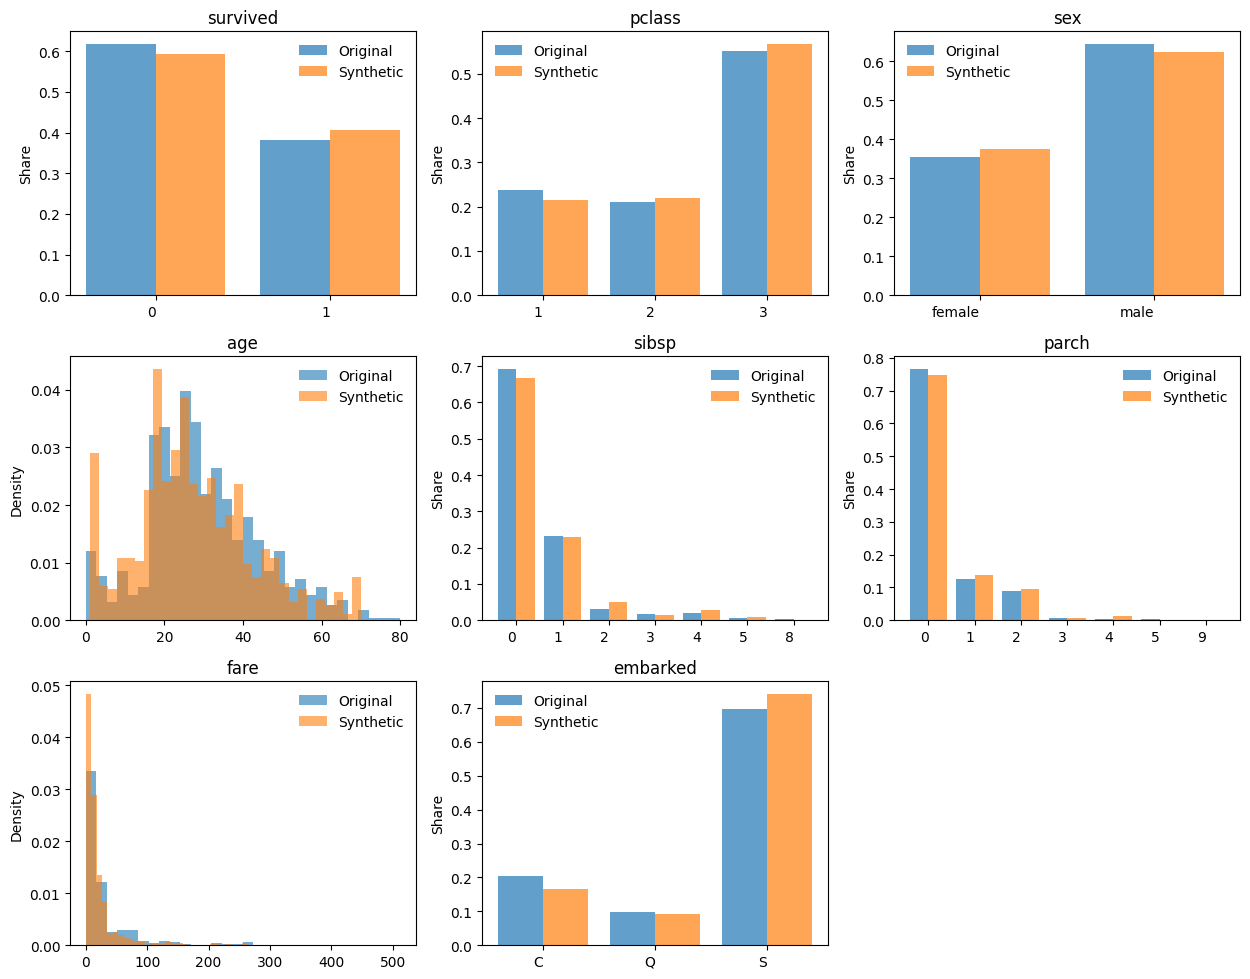

In [21]:
# Not exhaustive but we could compare the univariate distributions of the original and synthetic data:

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def is_categorical(series, max_unique=8):
    if series.dtype.name == "category":
        return True
    if pd.api.types.is_bool_dtype(series) or pd.api.types.is_object_dtype(series):
        return True
    if pd.api.types.is_integer_dtype(series) and series.nunique(dropna=False) <= max_unique:
        return True
    if pd.api.types.is_float_dtype(series):
        unique = series.dropna().unique()
        if len(unique) <= max_unique and np.allclose(unique, unique.astype(int)):
            return True
    return False

cols = list(X_train.columns)
n_cols = 3
n_rows = math.ceil(len(cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4.2, n_rows * 3.3))
axes = np.array(axes).ravel()

for ax in axes[len(cols):]:
    fig.delaxes(ax)

for idx, col in enumerate(cols):
    ax = axes[idx]
    orig = X_train[col]
    synth = X_syn[col]

    if is_categorical(orig):
        orig_counts = orig.fillna("Missing").astype(str).value_counts(normalize=True)
        synth_counts = synth.fillna("Missing").astype(str).value_counts(normalize=True)
        categories = sorted(set(orig_counts.index) | set(synth_counts.index))

        x = np.arange(len(categories))
        width = 0.4

        ax.bar(x - width / 2, [orig_counts.get(c, 0) for c in categories],
               width=width, alpha=0.7, color="#1f77b4", label="Original")
        ax.bar(x + width / 2, [synth_counts.get(c, 0) for c in categories],
               width=width, alpha=0.7, color="#ff7f0e", label="Synthetic")

        ax.set_xticks(x)
        ax.set_xticklabels(categories, rotation=0, ha="right")
        ax.set_ylabel("Share")
    else:
        combined = pd.concat([orig, synth], ignore_index=True).dropna()
        bins = min(30, max(10, int(np.sqrt(len(combined)))))

        ax.hist(orig.dropna(), bins=bins, alpha=0.6, density=True,
                label="Original", color="#1f77b4")
        ax.hist(synth.dropna(), bins=bins, alpha=0.6, density=True,
                label="Synthetic", color="#ff7f0e")
        ax.set_ylabel("Density")

    ax.set_title(col)
    ax.legend(frameon=False)

plt.tight_layout()
plt.show()


### A more exhaustive quality assessment

The **Quality Assurance** (QA) report organizes quality metrics around two concepts: fidelity and novelty. Fidelity tells us how well the model captured the distribution of the original data. At the same time we want to make sure we're not naively copy-pasting the original dataset; this is wat novelty metrics quantify.

More specifically, the report presents **accuracy**, **similarity** and **distance** metrics. Let's delve a bit into each one of these.

1. **Accuracy** metrics compare real and synthetic low-order marginal distributions, in particular, univariate and bivariate distributions:
      - Univariate accuracy compares discretized univariate distributions,
      - Bivariate accuracy compares the distribution of pairs of features via discretized bivariate contingency tables.
  
2. It could happen that we capture low-order marginals but still fail to properly model the full joint. We calculate a **similarity** score based on the cosine similarity of embeddings of records to inspect how higher-order distributions match:
   - each record is transformed into a string, 
   - each string-record is fed to a pre-trained language model to obtain embeddings,
   - we calculate centroids for the training and synthetic datasets,
   - we compute the cosine similarity between centroids.
   
3. While the two previous metrics assess the fidelity of the generator, the **distance** metrics informs about the capacity of the model to generate novel synthetic datasets. Using the embeddings calculated in (2), we compute the Distance to the Closest Record (DCR) of each synthetic record against training samples and hold-out samples. If our model is good, then the synthetic dataset will be "equally distant" from the training set and the hold-out set. 


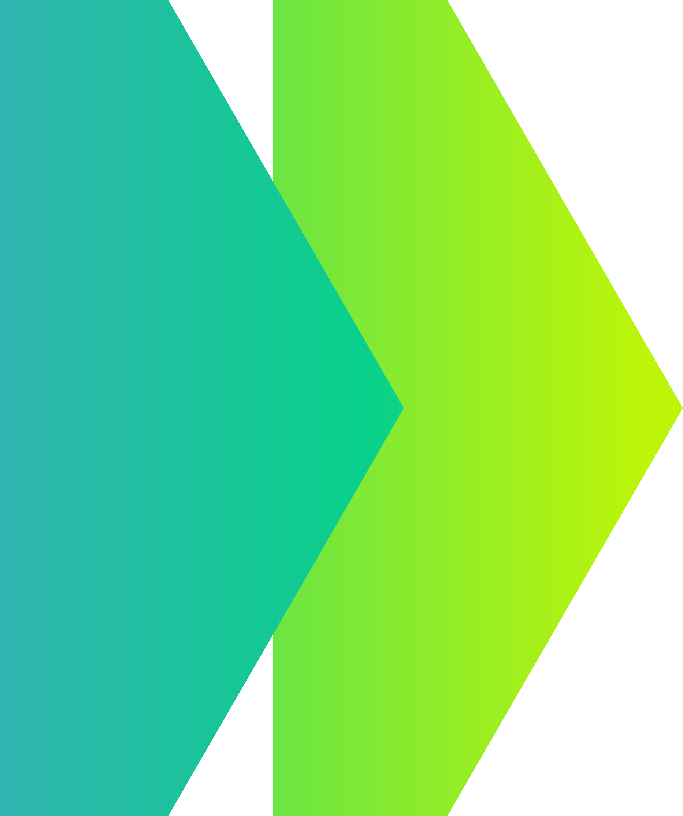
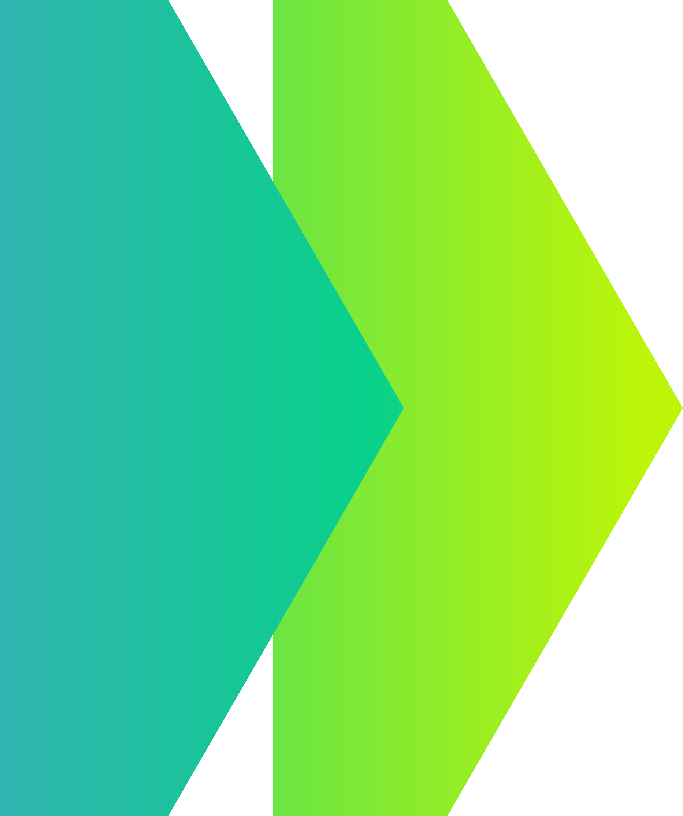
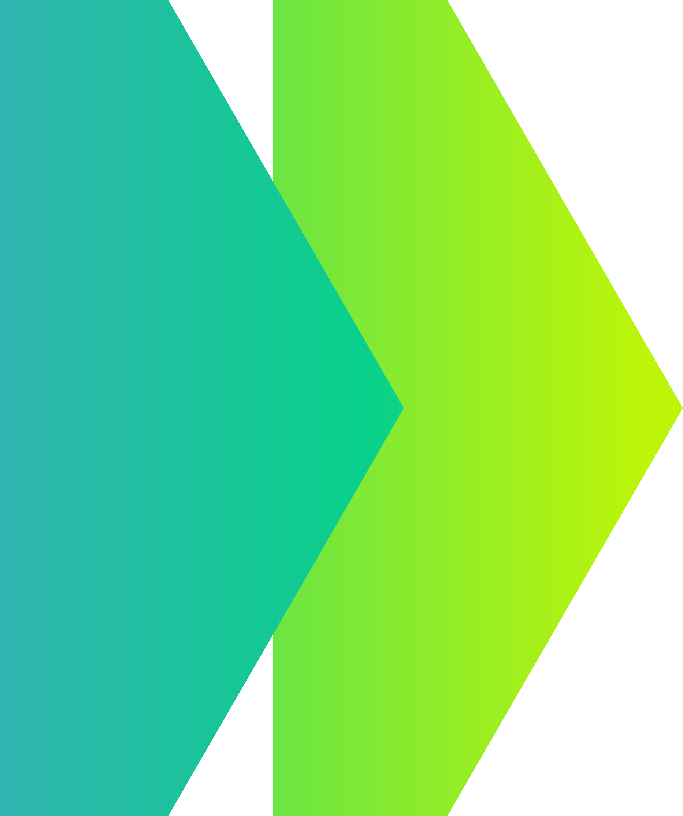

In [22]:
g.reports(display=True)

### Train-on-Synthetic / Test-on-Real (TSTR) 

Having assessed the main statistics of the real dataset are preserved in its synthetic counterpart, let's now check the utility of the generated dataset in terms of a simple but realistic downstream task.

One way we can check whether the generated synthetic dataset is useful is to train a model on it and then evaluate it in a real holdout set.

# ![TSTR](TSTR.png)


**Quiz:** Let's check whether we can predict the survival status of passengers from our synthetic dataset.

Task: predict the survival status of passengers

*Is the synthetic dataset useful?*

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler as SkStandardScaler

In [24]:
# Get training and hold-out sets for the downstream task (we drop Nan for now)

# Synthetic training set
y_syn_train = X_syn.dropna()['survived']
X_syn_train = X_syn.dropna().drop(columns=['survived'])

# Real training set
real_train_clean = X_train.dropna()
y_real_train = real_train_clean['survived']
X_real_train = real_train_clean.drop(columns=['survived'])

# Real test set (we use the hold-out set we prepared earlier)
y_real_test = X_ho.dropna()['survived']
X_real_test = X_ho.dropna().drop(columns=['survived'])

In [25]:
# Your code here
# ...
# ...
# ...
# ...
# ...
# ...
# ...

In [29]:
# Solution:

# Create preprocessing pipeline for categorical and numeric features
categorical_features = ['pclass', 'sex', 'embarked'] 
numeric_features = ['age', 'sibsp', 'parch', 'fare']

# Create preprocessing steps
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

preprocessor = ColumnTransformer(
    transformers=[
        ('num', SkStandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ])

# Create full pipeline
clf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=500))
])

# Fit and predict
clf.fit(X_syn_train, y_syn_train)
y_pred = clf.predict(X_real_test)
print(classification_report(y_real_test, y_pred))
tstr_report = classification_report(y_real_test, y_pred, output_dict=True)


              precision    recall  f1-score   support

           0       0.79      0.81      0.80       122
           1       0.72      0.69      0.70        84

    accuracy                           0.76       206
   macro avg       0.75      0.75      0.75       206
weighted avg       0.76      0.76      0.76       206



In [30]:
X_syn_train.dtypes, X_real_test.dtypes

(pclass               Int64
 sex         string[python]
 age                  Int64
 sibsp                Int64
 parch                Int64
 fare                 Int64
 embarked    string[python]
 dtype: object,
 pclass        int64
 sex          object
 age         float64
 sibsp         int64
 parch         int64
 fare        float64
 embarked     object
 dtype: object)

### Train-on-Real / Test-on-Real baseline

Before trusting the synthetic workflow, keep a reference: train the same classifier on the *real* training split and evaluate it on the real hold-out set. This anchors the benchmark we want the TSTR setup to approach.

In [32]:
# Rebuild the same preprocessing + model pipeline for a fair comparison
real_preprocessor = ColumnTransformer(
    transformers=[
        ('num', SkStandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ]
)

real_clf = Pipeline([
    ('preprocessor', real_preprocessor),
    ('classifier', LogisticRegression(max_iter=500))
])

real_clf.fit(X_real_train, y_real_train)
y_pred_real = real_clf.predict(X_real_test)

print('Train-on-Real / Test-on-Real performance:')
print(classification_report(y_real_test, y_pred_real))
real_clfrep = classification_report(y_real_test, y_pred_real, output_dict=True)

Train-on-Real / Test-on-Real performance:
              precision    recall  f1-score   support

           0       0.81      0.84      0.83       122
           1       0.76      0.71      0.74        84

    accuracy                           0.79       206
   macro avg       0.79      0.78      0.78       206
weighted avg       0.79      0.79      0.79       206



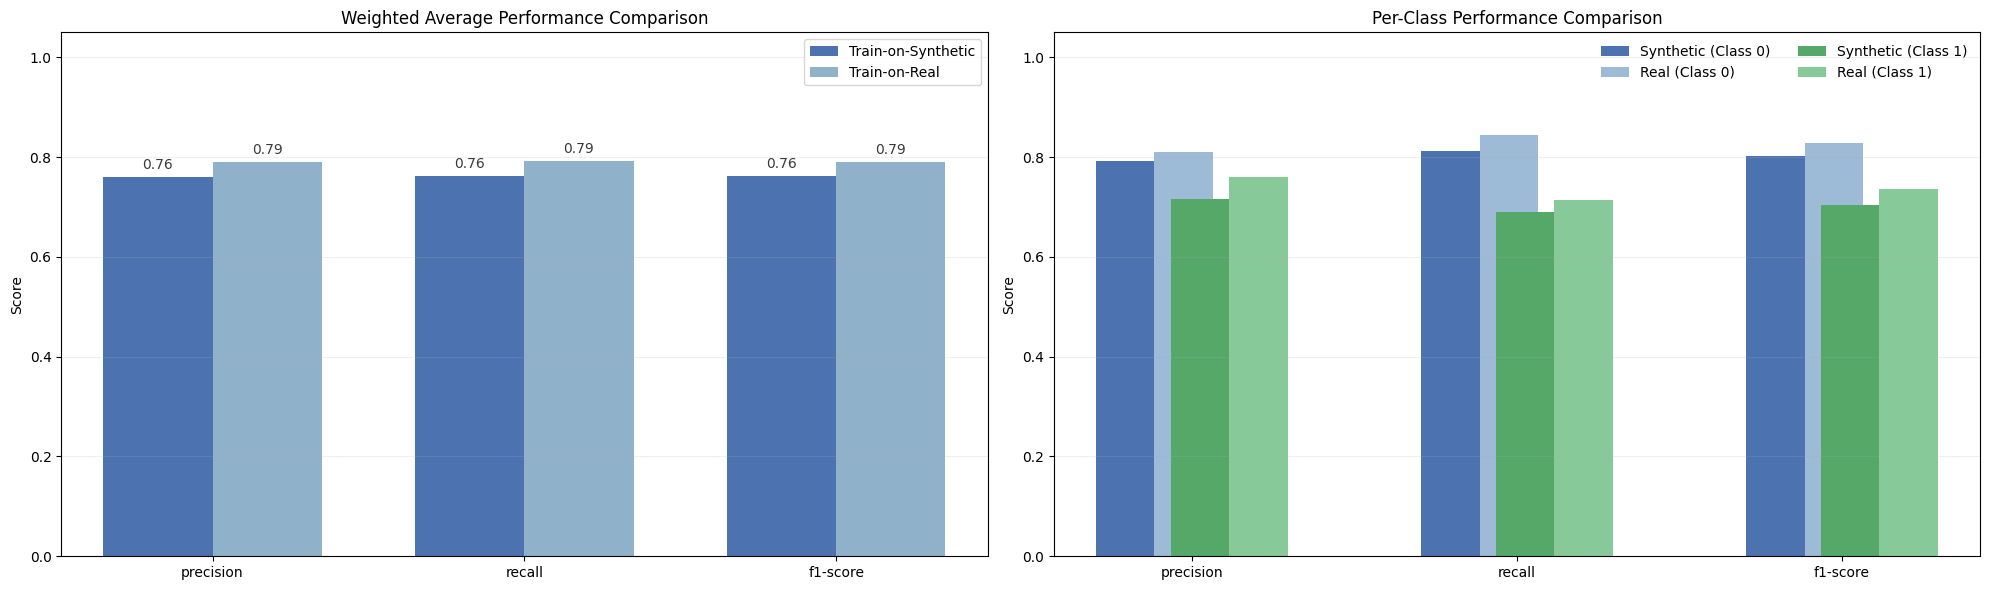

In [33]:
metrics = ['precision', 'recall', 'f1-score']

# Weighted average metrics
tstr_metrics = [tstr_report['weighted avg'][m] for m in metrics]
real_metrics = [real_clfrep['weighted avg'][m] for m in metrics]

# Per class metrics
tstr_metrics_0 = [tstr_report['0'][m] for m in metrics]
tstr_metrics_1 = [tstr_report['1'][m] for m in metrics]
real_metrics_0 = [real_clfrep['0'][m] for m in metrics]
real_metrics_1 = [real_clfrep['1'][m] for m in metrics]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Muted color palette keeps synthetic/real consistent across plots
synthetic_color = '#4C72B0'
real_color = '#8FB1C9'
synthetic_class_colors = ['#4C72B0', '#55A868']
real_class_colors = ['#9DBAD7', '#88C999']

# Plot 1: Weighted average comparison
x = np.arange(len(metrics))
width = 0.35

ax1.bar(x - width / 2, tstr_metrics, width, label='Train-on-Synthetic', color=synthetic_color)
ax1.bar(x + width / 2, real_metrics, width, label='Train-on-Real', color=real_color)

ax1.set_ylabel('Score')
ax1.set_title('Weighted Average Performance Comparison')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics)
ax1.set_ylim(0, 1.05)
ax1.legend()
ax1.grid(axis='y', alpha=0.2)

for i, metric in enumerate(metrics):
    ax1.text(i - width / 2, tstr_metrics[i] + 0.01, f'{tstr_metrics[i]:.2f}', ha='center', va='bottom', color='#3A3A3A')
    ax1.text(i + width / 2, real_metrics[i] + 0.01, f'{real_metrics[i]:.2f}', ha='center', va='bottom', color='#3A3A3A')

# Plot 2: Per-class comparison
width = 0.18
gap = 0.05

class0_positions = x - width - gap / 2
class1_positions = x + gap / 2

ax2.bar(class0_positions, tstr_metrics_0, width, label='Synthetic (Class 0)', color=synthetic_class_colors[0])
ax2.bar(class0_positions + width, real_metrics_0, width, label='Real (Class 0)', color=real_class_colors[0])
ax2.bar(class1_positions, tstr_metrics_1, width, label='Synthetic (Class 1)', color=synthetic_class_colors[1])
ax2.bar(class1_positions + width, real_metrics_1, width, label='Real (Class 1)', color=real_class_colors[1])

ax2.set_ylabel('Score')
ax2.set_title('Per-Class Performance Comparison')
ax2.set_xticks(x)
ax2.set_xticklabels(metrics)
ax2.set_ylim(0, 1.05)
ax2.grid(axis='y', alpha=0.2)
ax2.legend(ncol=2, frameon=False)

plt.tight_layout()
plt.show()


### A teaser for what comes next.

The `Titanic` dataset has some issues:
- missing values
- underrepresented categories

In [34]:
print("\nMissing values in X_train:")
print(X_train.isnull().sum())
print("\nPercentage of missing values:")
print((X_train.isnull().sum() / len(X_train) * 100).round(2), "%")



Missing values in X_train:
survived      0
pclass        0
sex           0
age         209
sibsp         0
parch         0
fare          1
embarked      0
dtype: int64

Percentage of missing values:
survived     0.00
pclass       0.00
sex          0.00
age         19.96
sibsp        0.00
parch        0.00
fare         0.10
embarked     0.00
dtype: float64 %


In [35]:
X_train.survived.value_counts(normalize=True)

survived
0    0.617956
1    0.382044
Name: proportion, dtype: float64

In [36]:
# Assess classifier quality separately for each survival class
def _extract_metrics(report, label):
    metrics = pd.DataFrame(report).T.loc[['0', '1'], ['precision', 'recall', 'f1-score', 'support']]
    metrics.index = metrics.index.map({'0': 'Did not survive (0)', '1': 'Survived (1)'})
    metrics.insert(0, 'Model', label)
    return metrics

summary_frames = []
if 'real_clfrep' in globals():
    summary_frames.append(_extract_metrics(real_clfrep, 'Train-on-Real/Test-on-Real'))
if 'tstr_report' in globals():
    summary_frames.append(_extract_metrics(tstr_report, 'TSTR (Baseline synthetic)'))
if not summary_frames:
    raise NameError('No classification reports found. Run the evaluation cells above first.')

quality_summary = pd.concat(summary_frames)
quality_summary = quality_summary.reset_index().rename(columns={'index': 'Survival class'})
quality_summary[['precision', 'recall', 'f1-score']] = quality_summary[['precision', 'recall', 'f1-score']].round(3)
display(quality_summary)


Survival class                       Model  precision  recall  \
0  Did not survive (0)  Train-on-Real/Test-on-Real      0.811   0.844   
1         Survived (1)  Train-on-Real/Test-on-Real      0.759   0.714   
2  Did not survive (0)   TSTR (Baseline synthetic)      0.792   0.811   
3         Survived (1)   TSTR (Baseline synthetic)      0.716   0.690   

   f1-score  support  
0     0.827    122.0  
1     0.736     84.0  
2     0.802    122.0  
3     0.703     84.0

## Coffee break

# ![coffee_break](coffee_break.png)
# 


## 2. Imputation & Rebalancing

We will:
- revisit the Titanic dataset and refresh the generator,
- configure smart imputation during sampling and validate the downstream utility (TSTR),
- rebalance whichever embarkation category performs worst so we can inspect the impact on model performance.

In [37]:
def run_tstr(synthetic_df, label):
    syn_subset = synthetic_df.dropna()
    if syn_subset.empty:
        raise ValueError('Synthetic data became empty after dropping NAs; check the configuration.')

    y_syn = syn_subset['survived']
    X_syn = syn_subset.drop(columns=['survived'])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', SkStandardScaler(), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ]
    )

    clf = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=500))
    ])

    # set seed for reproducibility
    np.random.seed(42)
    clf.fit(X_syn, y_syn)
    y_pred = clf.predict(X_real_test)

    print(f"=== {label} ===")
    print(classification_report(y_real_test, y_pred, digits=3))
    report = classification_report(y_real_test, y_pred, digits=3, output_dict=True)

    return clf, report, y_pred

### 2.1 Smart Imputation During Generation

We start by instructing the generator to impute the missing `age`, `fare` values when we sample. This keeps all downstream records usable without discarding rows.

In [38]:
print('Missing values in training data (selected columns):')
print(X_train[['age', 'fare']].isnull().sum())


Missing values in training data (selected columns):
age     209
fare      1
dtype: int64


In [39]:
imputation_config = {
    'name': 'Titanic Imputation Demo',
    'tables': [
        {
            'name': 'titanic',
            'configuration': {
                'imputation': {
                    'columns': ['age', 'fare']
                }
            }
        }
    ],
}

sd_imputed = mostly.generate(generator=g, config=imputation_config)
syn_imputed = sd_imputed.data()

print('Remaining missing values in synthetic sample (selected columns):')
print(syn_imputed[['age', 'fare']].isnull().sum())


Created synthetic dataset f2f707f4-98b9-4f9f-902d-5dd59a82a56d with generator 4fd26a15-60c7-4406-9ec1-bb486d9f3d59

Started synthetic dataset generation

Output()

🎉 Your synthetic dataset is ready! Use it to consume the generated data. Publish it so others can do the same.

Remaining missing values in synthetic sample (selected columns):
age     0
fare    0
dtype: int64


In [40]:
clf_imputed, report_imputed, _ = run_tstr(syn_imputed, label='TSTR with imputation-enabled synthetic data')

=== TSTR with imputation-enabled synthetic data ===
              precision    recall  f1-score   support

           0      0.824     0.885     0.854       122
           1      0.813     0.726     0.767        84

    accuracy                          0.820       206
   macro avg      0.819     0.806     0.811       206
weighted avg      0.820     0.820     0.818       206



What about a more straightforward but naive imputation mechanism?

In [41]:
# Implement naive imputation for comparison
X_train_naive = X_train.copy()

X_train_naive['age'] = X_train_naive['age'].fillna(X_train_naive['age'].mean())
X_train_naive['fare'] = X_train_naive['fare'].fillna(X_train_naive['fare'].mean())

# For categorical columns, use mode imputation
X_train_naive['embarked'] = X_train_naive['embarked'].fillna(X_train_naive['embarked'].mode()[0])

# Run TSTR evaluation with naive imputation
clf_naive, report_naive, _ = run_tstr(X_train_naive, label='TSTR with naive imputation')


=== TSTR with naive imputation ===
              precision    recall  f1-score   support

           0      0.819     0.852     0.835       122
           1      0.772     0.726     0.748        84

    accuracy                          0.801       206
   macro avg      0.796     0.789     0.792       206
weighted avg      0.800     0.801     0.800       206



A visual comparison between methods:

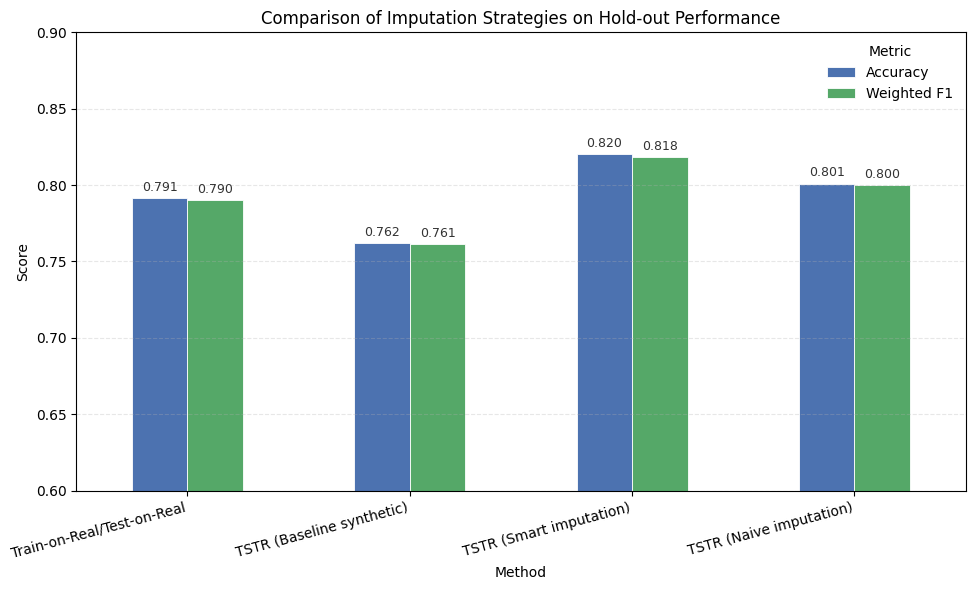

In [42]:
# Prepare comparison data for different imputation strategies
required_vars = {
    'report_imputed': 'Run the imputation-enabled TSTR cell first.',
    'report_naive': 'Run the naive imputation TSTR cell first.',
    'real_clfrep': 'Run the Train-on-Real / Test-on-Real baseline cell first.'
}

for var, msg in required_vars.items():
    if var not in globals():
        raise NameError(msg)

records = [
    ('Train-on-Real/Test-on-Real', 'Accuracy', real_clfrep['accuracy']),
    ('Train-on-Real/Test-on-Real', 'Weighted F1', real_clfrep['weighted avg']['f1-score']),
    ('TSTR (Smart imputation)', 'Accuracy', report_imputed['accuracy']),
    ('TSTR (Smart imputation)', 'Weighted F1', report_imputed['weighted avg']['f1-score']),
    ('TSTR (Naive imputation)', 'Accuracy', report_naive['accuracy']),
    ('TSTR (Naive imputation)', 'Weighted F1', report_naive['weighted avg']['f1-score']),
]

if 'tstr_report' in globals():
    records.extend([
        ('TSTR (Baseline synthetic)', 'Accuracy', tstr_report['accuracy']),
        ('TSTR (Baseline synthetic)', 'Weighted F1', tstr_report['weighted avg']['f1-score']),
    ])

comparison_df = pd.DataFrame(records, columns=['Method', 'Metric', 'Score'])
comparison_df['Method'] = pd.Categorical(
    comparison_df['Method'],
    categories=[
        'Train-on-Real/Test-on-Real',
        'TSTR (Baseline synthetic)',
        'TSTR (Smart imputation)',
        'TSTR (Naive imputation)'
    ],
    ordered=True
)
comparison_df = comparison_df.dropna(subset=['Method'])
pivot_df = comparison_df.pivot(index='Method', columns='Metric', values='Score').sort_index()

fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#4C72B0', '#55A868']
pivot_df.plot(kind='bar', ax=ax, color=colors, edgecolor='white', linewidth=0.6)

ax.set_title('Comparison of Imputation Strategies on Hold-out Performance')
ax.set_ylabel('Score')
ax.set_xlabel('Method')
ax.set_ylim(0.6, 0.9)
ax.grid(axis='y', linestyle='--', alpha=0.3)
ax.legend(title='Metric', frameon=False)
plt.xticks(rotation=15, ha='right')

for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3, fontsize=9, color='#333333')

plt.tight_layout()
plt.show()


### 2.2 Rebalancing Survival Outcomes

To understand how balancing the downstream target impacts utility, we'll bring the synthetic training split to a 50/50 mix of survivors and non-survivors, rerun the TSTR evaluation, and inspect how each class responds.

In [43]:
# Survival distribution in the synthetic training data
syn_base = X_syn.dropna()
survival_counts = syn_base['survived'].value_counts().sort_index()
survival_share = survival_counts / len(syn_base)
display(pd.DataFrame({
    'count': survival_counts,
    'share_pct': (survival_share * 100).round(2)
}))


count  share_pct
survived                  
0           462      57.25
1           345      42.75

In [44]:
# Upsample survivors to reach a 50/50 class balance
syn_base = X_syn.dropna().copy()
survival_counts = syn_base['survived'].value_counts().sort_index()
non_survivors = survival_counts.get(0, 0)
survivors = survival_counts.get(1, 0)
additional_survivors = max(non_survivors - survivors, 0)
print(f'Current survivors: {survivors}, non-survivors: {non_survivors}')
print(f'Additional survived=1 rows needed: {additional_survivors}')
if additional_survivors > 0:
    survivors_pool = syn_base[syn_base['survived'] == 1]
    if survivors_pool.empty:
        raise ValueError('No survived=1 rows available to upsample from.')
    extra_survivors = survivors_pool.sample(additional_survivors, replace=True, random_state=42)
    X_syn_balanced = pd.concat([syn_base, extra_survivors], ignore_index=True)
else:
    X_syn_balanced = syn_base.copy()

balanced_counts = X_syn_balanced['survived'].value_counts().sort_index()
display(pd.DataFrame({
    'count': balanced_counts,
    'share_pct': (balanced_counts / len(X_syn_balanced) * 100).round(2)
}))


Current survivors: 345, non-survivors: 462
Additional survived=1 rows needed: 117


count  share_pct
survived                  
0           462       50.0
1           462       50.0

In [45]:
# Re-run TSTR on the survival-balanced synthetic dataset
clf_balanced, report_balanced, y_pred_balanced = run_tstr(X_syn_balanced, label='TSTR with survival-balanced synthetic data')

=== TSTR with survival-balanced synthetic data ===
              precision    recall  f1-score   support

           0      0.822     0.721     0.769       122
           1      0.657     0.774     0.710        84

    accuracy                          0.743       206
   macro avg      0.739     0.748     0.739       206
weighted avg      0.755     0.743     0.745       206



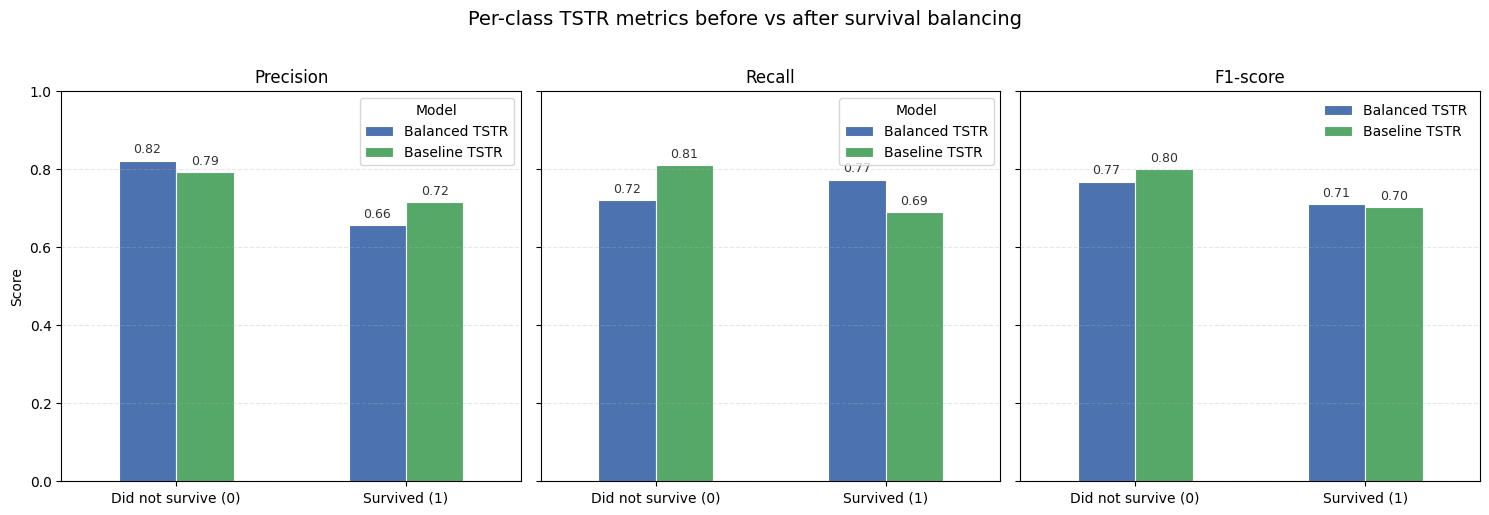

In [46]:
# Compare per-class performance before and after balancing
def _class_metrics(report, label):
    df = pd.DataFrame(report).T.loc[['0', '1'], ['precision', 'recall', 'f1-score']]
    df = df.rename(index={'0': 'Did not survive (0)', '1': 'Survived (1)'})
    df = df.reset_index().rename(columns={'index': 'Survival class'})
    df['Model'] = label
    return df

comparisons = []
if 'tstr_report' in globals():
    comparisons.append(_class_metrics(tstr_report, 'Baseline TSTR'))
comparisons.append(_class_metrics(report_balanced, 'Balanced TSTR'))
metrics_df = pd.concat(comparisons, ignore_index=True)
metric_order = ['precision', 'recall', 'f1-score']
metrics_df = metrics_df.melt(id_vars=['Survival class', 'Model'], value_vars=metric_order, var_name='Metric', value_name='Score')
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
colors = ['#4C72B0', '#55A868']
for ax, metric in zip(axes, metric_order):
    pivot = metrics_df[metrics_df['Metric'] == metric].pivot(index='Survival class', columns='Model', values='Score')
    pivot.plot(kind='bar', ax=ax, color=colors, edgecolor='white', linewidth=0.8)
    ax.set_title(metric.capitalize())
    ax.set_ylim(0, 1)
    ax.grid(axis='y', linestyle='--', alpha=0.3)
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', padding=3, fontsize=9, color='#333333')
    ax.set_xlabel('')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
axes[0].set_ylabel('Score')
axes[-1].legend(frameon=False)
plt.suptitle('Per-class TSTR metrics before vs after survival balancing', y=1.02, fontsize=14)
plt.tight_layout()
plt.show()


## [A very open-ended] Mini-challenge!

Let's take half an hour for trying to improve over the classic Train-Real/Test-Real baseline. There's actually a [kaggle competition](https://www.kaggle.com/competitions/titanic) on survival status prediction for `Titanic`! If you're feeling inspired, maybe you fetch the data, train a model by leveraging synthetic data, and make a submission.

Some pointers:
- maybe you do imputation of missing values in the training set,
- maybe you combine imputation and rebalancing,
- maybe you do some sort of post-processing to synthetic data before training the classifier,
- or you play around with the encoding types of the columns.

Have fun!